# Credit card approval analysis

## Goals:
### 1) Find out which factors contribute the most to good or bad credit.

Good credit defined as a loan less than 30 days overdue.
Bad credit defined as a loan 90 or more days overdue.

### 2) Create a model to predict who will default based on application records.

Defaulting defined as a credit status of 5: Overdue or bad debts, write-offs for more than 150 days

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import warnings
import pycaret

from pycaret.classification import *

# Data loading and validation

In [2]:
app = pd.read_csv('application_record.csv')
cr = pd.read_csv('credit_record.csv')

In [3]:
app.info

<bound method DataFrame.info of              ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  

In [4]:
cr.info

<bound method DataFrame.info of               ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]>

In [5]:
app['ID'].nunique() # we can see we have some duplicate IDs
#The credit_record table will have duplicates as it's a time series of months

438510

<AxesSubplot:>

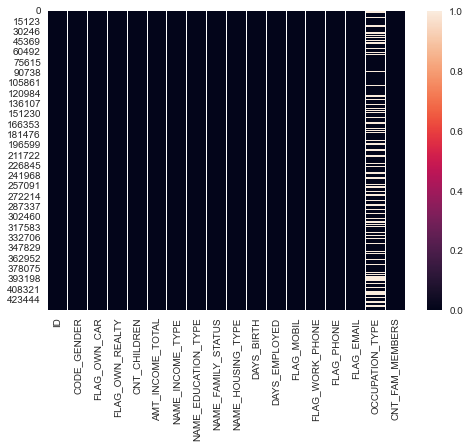

In [6]:
sns.heatmap(app.isnull()) # We have a lot of null values in occupation_type, let's drop that column


<AxesSubplot:>

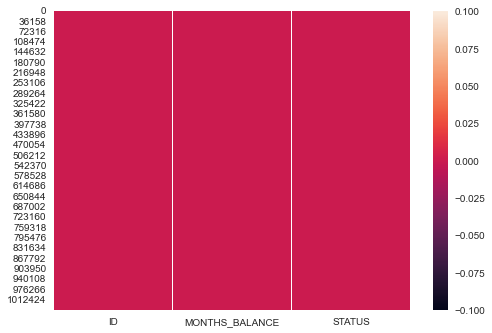

In [7]:
sns.heatmap(cr.isnull())# no nulls here

In [8]:
app = app.drop_duplicates('ID',keep='last') # drop duplicates in the application table, keeping the last entry
app = app.drop('OCCUPATION_TYPE',axis=1) # dropping the occupation_type to not deal with nulls on a categorical variable
app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0


# Data cleaning

In [9]:
#Let's start with the good/bad credit table
#lets group the credit records by number of bad months (>= 3) and good months (C, X or 0)
# We'll make good credit 0 and bad credit 1 then group each id by their counts of good and bad credit months
replaceDict = {'X':0,'C':0,'0':0,'3':1,'4':1,'5':1}
gb = cr.copy()
gb['STATUS'] = gb['STATUS'].replace(replaceDict) 
gb['good_credit'] = np.where(gb['STATUS']==0,1,0)
gb['bad_credit'] = np.where(gb['STATUS']==1,1,0)
gb = gb[['ID','good_credit','bad_credit']].groupby('ID').sum().reset_index()
len(gb)


45985

In [10]:
#Now let's do the same but grouping by anyone who's defaulted (status = 5)
replaceDict = {'X':0,'C':0,'0':0,'3':0,'4':0,'5':1}
ddf = cr.copy()
ddf['STATUS'] = ddf['STATUS'].replace(replaceDict)
ddf['defaults'] = np.where(ddf['STATUS'] == 1, 1, 0)
ddf = ddf[['ID','defaults']].groupby('ID').sum()
len(ddf)


45985

In [11]:
mb = cr[['ID','MONTHS_BALANCE']].groupby('ID').count() # Total number of months tracked will be useful as well
mb = mb.rename(columns={'MONTHS_BALANCE':'total_months'})

In [12]:
#Let's merge these two so we can merge with the application dataframe
cr_clean = ddf.merge(gb, on='ID')
cr_clean = cr_clean.merge(mb, on='ID')
len(cr_clean)

45985

In [13]:
len(set(cr_clean['ID']).intersection(set(app['ID']))) # lets check how many IDs we have intersecting in both data frames


36457

In [14]:
df = app.merge(cr_clean, on='ID', how='inner') # Merge credit report and application dataframes and validate to see if we got the same number of IDs
df['ID'].nunique()

36457

In [15]:
df = df.rename(columns={'ID':'id','CODE_GENDER':'gender','FLAG_OWN_REALTY':'realty','CNT_CHILDREN':'cnt_children',
              'AMT_INCOME_TOTAL':'total_income','NAME_INCOME_TYPE':'income_type','NAME_EDUCATION_TYPE':'education',
              'NAME_FAMILY_STATUS':'family_status','NAME_HOUSING_TYPE':'housing_type','DAYS_BIRTH':'days_birth',
               'DAYS_EMPLOYED':'days_employed','FLAG_MOBIL':'mobile_phone','FLAG_WORK_PHONE':'work_phone','FLAG_PHONE':'phone',
              'FLAG_EMAIL':'email','CNT_FAM_MEMBERS':'family_size','FLAG_OWN_CAR':'car'})
df = df.reset_index()
df = df.drop('index', axis=1)
df.to_csv('clean_data.csv') # Save the dataframe just incase

# WOE and IV analysis

We'll be using WOE (Weight of Evidence) and IV (Information Value) to decide which factors most heavily contribute to good performance (No loan, credit for the month paid off, or 0-29 days past due) and bad performance (>= 90 days past due)

## WOE
The formula for WOE is as follows $$WOE = ln(\frac{\text{number  of  good in class}}{\text{number of total good}}) - ln(\frac{\text{number of bad in class}}{\text{number of total bad}})$$

Negative values will mean that $\text{distribution of good} > \text{distribution of bad}$ and positive will mean the opposite is true.

## IV
Information value is how strong the variable will be as a predictor for the target. Generally .10 - .30 indicates medium predictive power while .30 and higher indicates a strong predictor. Above .50 is suspicious and should be evaluated further. The formula for IV is as follows $$WOE * (\text{proportion of all good in class} - \text{proportion of all bad in class}) $$

In [16]:
good_total = df['good_credit'].sum()
bad_total = df['bad_credit'].sum()

def calculateIv(df, feature,good_total=good_total,bad_total=bad_total): #let's make a function to calculate WoE and IV and return a dataframe
    x = []
    for i in range(df[feature].nunique()):
        var = list(df[feature].unique())[i]
        x.append([feature,   # Variable
                  var,       #unique values
                  df[df[feature] == var].sum()['good_credit'] + df[df[feature] == var].sum()['bad_credit'], # Good and bad months
                  df[(df[feature] == var) & (df['good_credit'] > 0)].sum()['good_credit'], # Sum of good months
                  df[(df[feature] == var) & (df['bad_credit'] > 0)].sum()['bad_credit']]) # Sum of bad months
        
    data = pd.DataFrame(x, columns=['variable','value','all','good','bad'])
    data['proportion'] = data['all'] / data['all'].sum()
    data['woe'] = (np.log(data['good']/good_total)) - (np.log(data['bad']/bad_total))
    
    data = data.replace({'WoE':{np.inf:0, -np.inf: 0}})
    data['iv'] = data['woe'] * (data['good']/good_total - data['bad']/bad_total)
    
    data = data.sort_values(by=['iv'], ascending=False)
    data.index = range(len(data.index))
    
    iv = data['iv'].sum()
    print('IV:', iv)
    return iv, data

def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

ivtablecols = list(df.columns)
dropcols = ['id','good_credit','bad_credit','total_months','defaults']

for i in dropcols:
    ivtablecols.remove(i)


ivtable=pd.DataFrame(ivtablecols,columns=['variable'])
ivtable['IV']=None




### Gender (0 = Male, 1 = Female)

In [17]:
df['gender'] = df['gender'].replace(['M','F'],[0,1])
iv, data = calculateIv(df,'gender')
ivtable.loc[ivtable['variable'] == 'gender','IV'] = iv
data.head()

IV: 0.011391875104362553


,variable,value,all,good,bad,proportion,woe,iv
0,gender,0,258573,254444,4129,0.332821,-0.143184,0.007320
1,gender,1,518341,511696,6645,0.667179,0.079637,0.004072


### Owning a car (No = 0, Yes = 1)

In [18]:
df['car'] = df['car'].replace(['N','Y'],[0,1])
iv, data = calculateIv(df,'car')
ivtable.loc[ivtable['variable'] == 'car','IV'] = iv
data.head()

IV: 0.0009517842411933399


,variable,value,all,good,bad,proportion,woe,iv
0,car,1,304046,299989,4057,0.391351,0.039073,0.000586
1,car,0,472868,466151,6717,0.608649,-0.024361,0.000366


### Owning real estate (No = 0, Yes = 1)

In [19]:
df['realty'] = df['realty'].replace(['N','Y'],[0,1])
iv, data = calculateIv(df,'realty')
ivtable.loc[ivtable['variable'] == 'realty','IV'] = iv
data.head()

IV: 0.004948035635690686


,variable,value,all,good,bad,proportion,woe,iv
0,realty,0,264434,260409,4025,0.340365,-0.094501,0.003183
1,realty,1,512480,505731,6749,0.659635,0.052381,0.001765


### Owning a phone (No = 0, Yes = 1)

In [20]:
iv, data = calculateIv(df,'phone')
ivtable.loc[ivtable['variable'] == 'phone','IV'] = iv
data.head()

IV: 0.0003943897121541348


,variable,value,all,good,bad,proportion,woe,iv
0,phone,1,233840,230500,3340,0.300986,-0.029949,0.000274
1,phone,0,543074,535640,7434,0.699014,0.013169,0.000120


### Owning a work phone (No = 0, Yes = 1)

In [21]:
iv, data = calculateIv(df,'work_phone')
ivtable.loc[ivtable['variable'] == 'work_phone','IV'] = iv
data.head()

IV: 0.0016452552699512428


,variable,value,all,good,bad,proportion,woe,iv
0,work_phone,1,180054,177373,2681,0.231755,-0.072164,0.001250
1,work_phone,0,596860,588767,8093,0.768245,0.022802,0.000395


### Owning a cell phone (No = 0, Yes = 1)

In [22]:
iv, data = calculateIv(df,'mobile_phone')
ivtable.loc[ivtable['variable'] == 'mobile_phone','IV'] = iv
data.head()

IV: 0.0


,variable,value,all,good,bad,proportion,woe,iv
0,mobile_phone,1,776914,766140,10774,1.0,0.0,0.0


### Having an email address

In [23]:
iv, data = calculateIv(df,'email')
ivtable.loc[ivtable['variable'] == 'email','IV'] = iv
data.head()

IV: 0.00033867228212164477


,variable,value,all,good,bad,proportion,woe,iv
0,email,1,71235,70190,1045,0.09169,-0.057040,0.000307
1,email,0,705679,695950,9729,0.90831,0.005938,0.000032


## Continuous variables
We need to create categories for these.

### Child count

In [24]:
df['cnt_children'].loc[df['cnt_children'] >= 2] = '2More'
iv, data = calculateIv(df,'cnt_children')
ivtable.loc[ivtable['variable'] == 'cnt_children','IV'] = iv
data.head()


IV: 0.002223681666877664


,variable,value,all,good,bad,proportion,woe,iv
0,cnt_children,1,155482,153150,2332,0.200128,-0.079538,0.001316
1,cnt_children,0,540080,532819,7261,0.695161,0.031435,0.000677
2,cnt_children,2More,81352,80171,1181,0.104712,-0.046429,0.000231


### Income

<AxesSubplot:ylabel='Frequency'>

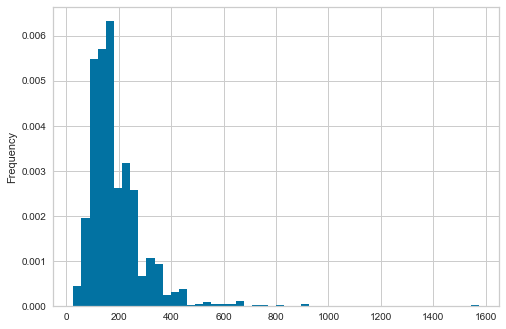

In [25]:
df['total_income'] = df['total_income'] / 1000
df['total_income'].plot(kind='hist',bins=50, density=True)

In [26]:
df = get_category(df,'total_income',3,["low","medium","high"], qcut=True)
iv, data = calculateIv(df, 'gp_total_income')
ivtable.loc[ivtable['variable'] == 'total_income','IV'] = iv
data.head()

IV: 0.00022937530931385006


,variable,value,all,good,bad,proportion,woe,iv
0,gp_total_income,high,246521,243033,3488,0.317308,-0.020360,1.328486e-04
1,gp_total_income,low,301532,297415,4117,0.388115,0.015775,9.584119e-05
2,gp_total_income,medium,228861,225692,3169,0.294577,0.001526,6.855204e-07


### Age

<AxesSubplot:ylabel='Frequency'>

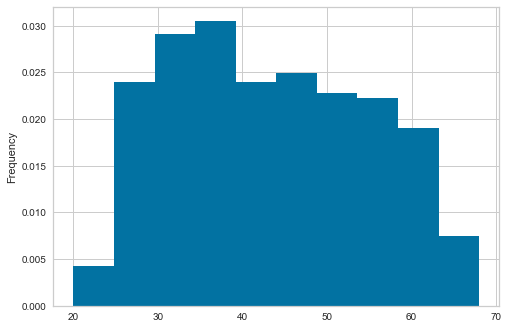

In [27]:
df['age'] = -(df['days_birth'])//365
df['age'].plot(kind='hist',bins=10,density=True)

In [28]:
df = get_category(df,'age',5,["lowest","low","medium","high","Highest"])
iv, data = calculateIv(df, 'gp_age')
ivtable.loc[ivtable['variable'] == 'days_birth','IV'] = iv
data.head()

IV: 0.015063950522956416


,variable,value,all,good,bad,proportion,woe,iv
0,gp_age,lowest,89739,88132,1607,0.115507,-0.259762,0.008864
1,gp_age,Highest,98769,97614,1155,0.127130,0.172691,0.003490
2,gp_age,medium,190971,188499,2472,0.245807,0.069836,0.001159
3,gp_age,low,223335,220074,3261,0.287464,-0.052299,0.000807
4,gp_age,high,174100,171821,2279,0.224092,0.058487,0.000745


### Working experience

<AxesSubplot:ylabel='Frequency'>

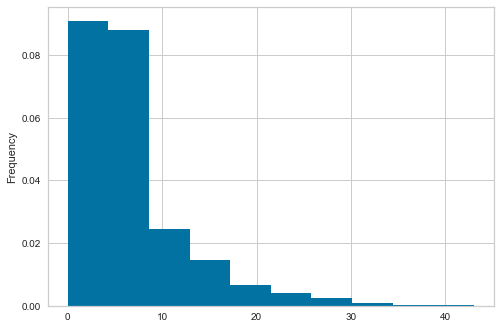

In [29]:
df['experience'] = -(df['days_employed'])//365 # lots of weird values on this column, taking them out and using mean
df[df['experience']<0] = np.nan
df['experience'] = df['experience'].fillna(df['experience'].mean())
df['experience'].plot(kind='hist',bins=10,density=True)

In [30]:
df = get_category(df,'experience',5,["lowest","low","medium","high","Highest"])
iv, data = calculateIv(df, 'gp_experience')
ivtable.loc[ivtable['variable'] == 'days_employed','IV'] = iv
data.head()

IV: 0.006834248943553079


,variable,value,all,good,bad,proportion,woe,iv
0,gp_experience,lowest,453881.0,447052.0,6829.0,0.699256,-0.082732,0.004164
1,gp_experience,low,141413.0,139639.0,1774.0,0.217863,0.101595,0.001789
2,gp_experience,medium,37949.0,37472.0,477.0,0.058465,0.099604,0.000462
3,gp_experience,high,12793.0,12641.0,152.0,0.019709,0.156591,0.000374
4,gp_experience,Highest,3055.0,3017.0,38.0,0.004707,0.110203,0.000045


### Family Size

In [31]:
df['family_size'].loc[df['family_size'] >= 3] = '3More'
iv, data = calculateIv(df,'family_size')
ivtable.loc[ivtable['variable'] == 'family_size','IV'] = iv
data.head()

IV: 0.0008537979572455084


,variable,value,all,good,bad,proportion,woe,iv
0,family_size,1.0,103112.0,101567.0,1545.0,0.233899,-0.078534,0.000851
1,family_size,2.0,337728.0,333057.0,4671.0,0.766101,0.002711,0.000003
2,family_size,NaN,0.0,0.0,0.0,0.000000,NaN,NaN


# Categorical Variables

## Income type

In [32]:
df['income_type'].loc[df['income_type'] == 'Pensioner'] = 'State Servant'
df['income_type'].loc[df['income_type'] == 'Student'] = 'State Servant'
iv, data = calculateIv(df,'income_type')
ivtable.loc[ivtable['variable'] == 'income_type','IV'] = iv
data.head()

IV: 0.011721246702601103


,variable,value,all,good,bad,proportion,woe,iv
0,income_type,Commercial associate,183198.0,180120.0,3078.0,0.282557,-0.194886,0.009859
1,income_type,Working,399762.0,394514.0,5248.0,0.616576,0.055578,0.001547
2,income_type,State servant,65398.0,64545.0,853.0,0.100867,0.062129,0.000315
3,income_type,NaN,0.0,0.0,0.0,0.000000,NaN,NaN


## Housing Type

In [33]:
iv, data = calculateIv(df,'housing_type')
ivtable.loc[ivtable['variable'] == 'housing_type','IV'] = iv
data.head()

IV: 0.0007396086211950189


,variable,value,all,good,bad,proportion,woe,iv
0,housing_type,House / apartment,573564.0,565433.0,8131.0,0.890485,-0.022321,3.718470e-04
1,housing_type,With parents,35591.0,35067.0,524.0,0.055257,-0.060705,1.738953e-04
2,housing_type,Rented apartment,10254.0,10096.0,158.0,0.015920,-0.106930,1.590241e-04
3,housing_type,Municipal apartment,21098.0,20795.0,303.0,0.032756,-0.035494,3.480905e-05
4,housing_type,Co-op apartment,3596.0,3546.0,50.0,0.005583,-0.002677,3.320350e-08


## Education

In [34]:
df['education'].loc[df['education'] == 'Academic degree'] = 'Higher education'
iv, data = calculateIv(df,'education')
ivtable.loc[ivtable['variable'] == 'education','IV'] = iv
data.head()

IV: 0.005357406685283983


,variable,value,all,good,bad,proportion,woe,iv
0,education,Incomplete higher,29082.0,28516.0,566.0,0.045164,-0.344603,0.005277
1,education,Higher education,192173.0,189463.0,2710.0,0.298446,-0.016984,0.000072
2,education,Secondary / secondary special,422658.0,416774.0,5884.0,0.656390,-0.003922,0.000008
3,education,NaN,0.0,0.0,0.0,0.000000,NaN,NaN


## Marital status

In [35]:
iv, data = calculateIv(df,'family_status')
ivtable.loc[ivtable['variable'] == 'family_status','IV'] = iv
data.head()

IV: 0.009219119353374512


,variable,value,all,good,bad,proportion,woe,iv
0,family_status,Single / not married,79693.0,78253.0,1440.0,0.125616,-0.268925,8.475388e-03
1,family_status,Separated,37692.0,37231.0,461.0,0.059412,0.127270,7.391025e-04
2,family_status,Civil marriage,52910.0,52182.0,728.0,0.083399,0.007963,4.301401e-06
3,family_status,Married,464122.0,457681.0,6441.0,0.731572,-0.000740,3.276645e-07
4,family_status,NaN,0.0,0.0,0.0,0.000000,NaN,NaN


In [36]:
ivtable = ivtable.sort_values(by='IV', ascending=False)
ivtable

,variable,IV
9,days_birth,0.015064
5,income_type,0.0117212
0,gender,0.0113919
7,family_status,0.00921912
10,days_employed,0.00683425
6,education,0.00535741
2,realty,0.00494804
3,cnt_children,0.00222368
12,work_phone,0.00164526
1,car,0.000951784


# Defaults prediction cleaning


In [37]:
df = pd.read_csv('clean_data.csv')


In [38]:
df['default'] = 0
df['default'].loc[df['defaults'] > 0] = 1 # make a true/false indicator variable of if the person has ever had a credit status of 5


## Feature engineering
Turning continuous and categorical variables into dummy variables

In [39]:
df['experience'] = -(df['days_employed'])//365 # lots of weird values on this column, taking them out and using mean
df[df['experience']<0] = np.nan
df['experience'] = df['experience'].fillna(df['experience'].mean())
df = get_category(df,'experience',5,["lowest","low","medium","high","Highest"])
df = convert_dummy(df,'gp_experience')


In [40]:
df['gender'] = df['gender'].replace(['M','F'],[0,1])

df['car'] = df['car'].replace(['N','Y'],[0,1])

df['realty'] = df['realty'].replace(['N','Y'],[0,1])

df['cnt_children'].loc[df['cnt_children'] >= 2] = '2More'
df = convert_dummy(df,'cnt_children')

df = get_category(df,'total_income',3,["low","medium","high"], qcut=True)
df = convert_dummy(df,'gp_total_income')

df['age'] = -(df['days_birth'])//365
df = get_category(df,'age',5,["lowest","low","medium","high","Highest"])
df = convert_dummy(df,'gp_age')

df['family_size'].loc[df['family_size'] >= 3] = '3More'
df = convert_dummy(df,'family_size')

df = convert_dummy(df,'income_type')

df = convert_dummy(df,'housing_type')

df = convert_dummy(df,'family_status')

df = convert_dummy(df,'education')

In [41]:
df = df.drop(columns=['total_income','days_birth','days_employed','good_credit','bad_credit',
                     'defaults','total_months','experience','age','Unnamed: 0'])
df.head()

,id,gender,car,realty,mobile_phone,work_phone,phone,email,default,gp_experience_Highest,gp_experience_high,gp_experience_low,gp_experience_medium,cnt_children_1.0,cnt_children_2More,gp_total_income_high,gp_total_income_medium,gp_age_Highest,gp_age_high,gp_age_low,gp_age_lowest,family_size_1.0,family_size_3More,income_type_Commercial associate,income_type_Pensioner,income_type_State servant,income_type_Student,housing_type_Co-op apartment,housing_type_Municipal apartment,housing_type_Office apartment,housing_type_Rented apartment,housing_type_With parents,family_status_Civil marriage,family_status_Separated,family_status_Single / not married,family_status_Widow,education_Academic degree,education_Higher education,education_Incomplete higher,education_Lower secondary
0,5008804.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
1,5008805.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
2,5008806.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5008808.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5008809.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [42]:
X = df.loc[:, df.columns != 'default']
Y = df['default']

# Building a model
Finally we can build our model, we'll try to get the most accurate model in terms of estimating a status 5 ever occuring.

In [43]:
df['default'].value_counts() # Huge imbalance of default rate, we should fix this imbalance before training the model

0.0    26715
1.0     3607
Name: default, dtype: int64

In [44]:
stp = setup(df, target='default', train_size = 0.8, ignore_features=['id'], fix_imbalance = True, silent = True, session_id = 1)
#Using SMOTE to fix the imbalance of having so few defaults in the dataset - this should increase accuracy

,Description,Value
0,session_id,1
1,Target,default
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(36457, 40)"
5,Missing Values,True
6,Numeric Features,31
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [45]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8805,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0860
knn,K Neighbors Classifier,0.8402,0.6842,0.3390,0.3344,0.3363,0.2456,0.2457,2.8560
et,Extra Trees Classifier,0.7948,0.7184,0.4381,0.2750,0.3378,0.2238,0.2324,0.9590
rf,Random Forest Classifier,0.7907,0.7242,0.4564,0.2743,0.3425,0.2272,0.2377,0.9060
dt,Decision Tree Classifier,0.7893,0.7029,0.4501,0.2707,0.3380,0.2219,0.2321,0.1390
lightgbm,Light Gradient Boosting Machine,0.7663,0.6117,0.3103,0.1971,0.2409,0.1110,0.1150,0.1650
gbc,Gradient Boosting Classifier,0.7408,0.5454,0.2327,0.1425,0.1766,0.0334,0.0348,0.8310
ada,Ada Boost Classifier,0.6617,0.5140,0.3110,0.1270,0.1801,0.0126,0.0146,0.3260
lr,Logistic Regression,0.5329,0.5015,0.4574,0.1197,0.1897,0.0003,0.0004,0.5800
lda,Linear Discriminant Analysis,0.5314,0.5016,0.4588,0.1195,0.1896,0.0000,0.0000,0.1610


Our dummy classifier did better than every other model. Lets investigate why.

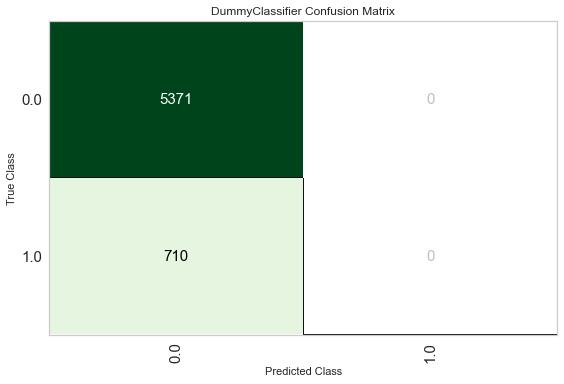

In [46]:
plot_model(best_model, plot = 'confusion_matrix') # It looks like it just predicted everything as not having a default

It looks like it just predicted everything as not having a default. This makes sense, the data is so skewed in that direction it will have a pretty high accuracy. Since this problem is so imbalanced accuracy won't be a good metric. Recall would be a good metric to optimize for as high recall does well in finding positive cases. We don't ever want to loan to anyone that will end up defaulting so if we exclude a few false positives as collateral to be safe and have a higher likelihood of predicting bad credit it will be worth it.

The random forest classifier has a really good balance of accuracy and recall, let's try to tune that and optimize for recall.

In [47]:
rf = create_model('rf')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7918,0.7146,0.4310,0.2688,0.3311,0.2156,0.2240
1,0.7966,0.7208,0.4844,0.2893,0.3622,0.2503,0.2621
2,0.7855,0.7177,0.4429,0.2628,0.3299,0.2120,0.2222
3,0.7962,0.7289,0.4983,0.2921,0.3683,0.2565,0.2695
4,0.7892,0.7262,0.4448,0.2693,0.3355,0.2191,0.2289
5,0.7937,0.7342,0.4207,0.2687,0.3280,0.2131,0.2205
6,0.7756,0.7117,0.4483,0.2529,0.3234,0.2012,0.2130
7,0.7970,0.7294,0.4828,0.2905,0.3627,0.2508,0.2622
8,0.7925,0.7337,0.4586,0.2777,0.3459,0.2313,0.2416


In [48]:
tune_rf = tune_model(rf, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4837,0.4680,0.4517,0.1070,0.1731,-0.0252,-0.0391
1,0.4880,0.5225,0.5675,0.1281,0.2091,0.0180,0.0291
2,0.4670,0.4950,0.5467,0.1198,0.1965,0.0011,0.0019
3,0.5454,0.5323,0.5087,0.1328,0.2106,0.0265,0.0384
4,0.5066,0.5415,0.5897,0.1370,0.2224,0.0350,0.0552
5,0.5083,0.5051,0.5034,0.1223,0.1968,0.0053,0.0080
6,0.4922,0.4831,0.4793,0.1140,0.1842,-0.0112,-0.0174
7,0.5173,0.5038,0.4897,0.1220,0.1953,0.0047,0.0070
8,0.5066,0.4891,0.4621,0.1141,0.1831,-0.0109,-0.0164


let's check feature importance and the confusion matrix.

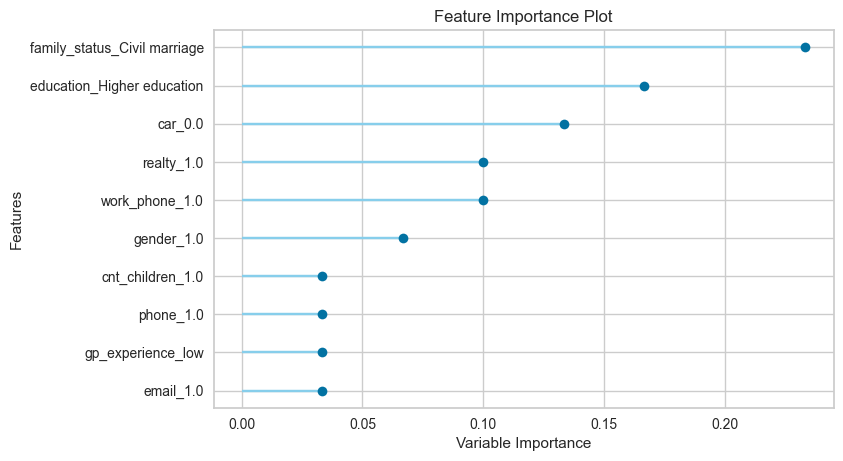

In [63]:
plot_model(tune_rf,plot='feature')

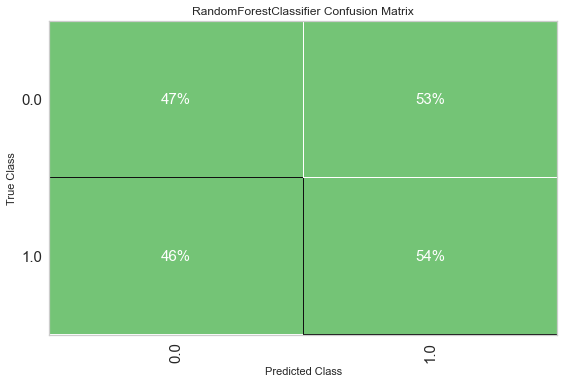

In [64]:
plot_model(tune_rf,plot='confusion_matrix', plot_kwargs= {'percent': True})

We are predicting 54% of the bad credit group with a 53% false positive rate for bad credit. lets see if we can make a better model

In [50]:
et = create_model('et')

tune_et = tune_model(et, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3588,0.4654,0.6034,0.1084,0.1837,-0.0239,-0.0489
1,0.3993,0.5353,0.7197,0.1314,0.2222,0.0258,0.0515
2,0.3890,0.4877,0.6263,0.1165,0.1964,-0.0058,-0.0113
3,0.3585,0.5063,0.7059,0.1219,0.2078,0.0057,0.0122
4,0.3461,0.5080,0.7207,0.1220,0.2087,0.0051,0.0113
5,0.3321,0.4940,0.7069,0.1179,0.2021,-0.0038,-0.0086
6,0.3358,0.5065,0.7552,0.1246,0.2139,0.0107,0.0247
7,0.3507,0.5105,0.7207,0.1228,0.2098,0.0068,0.0149
8,0.3535,0.5177,0.7586,0.1281,0.2192,0.0183,0.0408


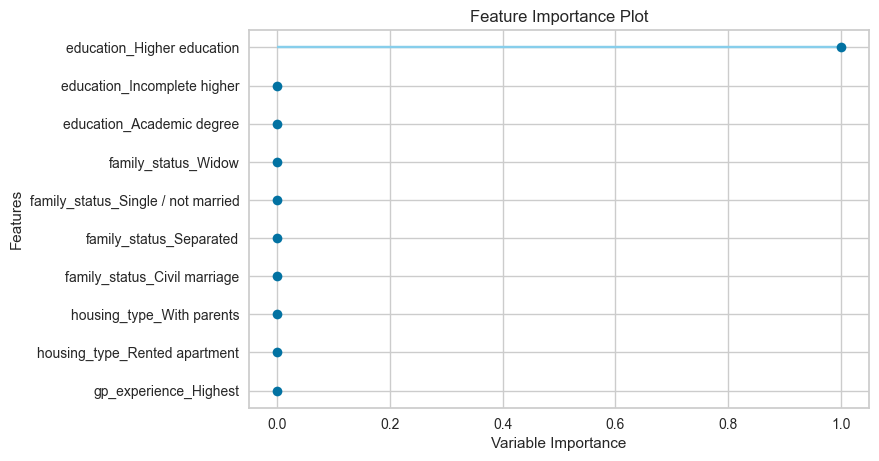

In [65]:
plot_model(tune_et,plot='feature')

The extra trees classifier is just selecting for anyone with higher education, it's getting the people who default right 70% of the time. This is good to know but probably not the best model to deploy.

In [66]:
gbc = create_model('gbc')
tune_gbc = tune_model(gbc, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3278,0.4693,0.6552,0.1105,0.1891,-0.0196,-0.0439
1,0.3993,0.5296,0.7197,0.1314,0.2222,0.0258,0.0515
2,0.3395,0.4994,0.7093,0.1190,0.2039,-0.0004,-0.0009
3,0.3585,0.5087,0.7059,0.1219,0.2078,0.0057,0.0122
4,0.3461,0.5080,0.7207,0.1220,0.2087,0.0051,0.0113
5,0.3321,0.4940,0.7069,0.1179,0.2021,-0.0038,-0.0086
6,0.4253,0.4935,0.5621,0.1141,0.1896,-0.0116,-0.0206
7,0.3507,0.5105,0.7207,0.1228,0.2098,0.0068,0.0149
8,0.4307,0.4845,0.5552,0.1140,0.1892,-0.0116,-0.0204


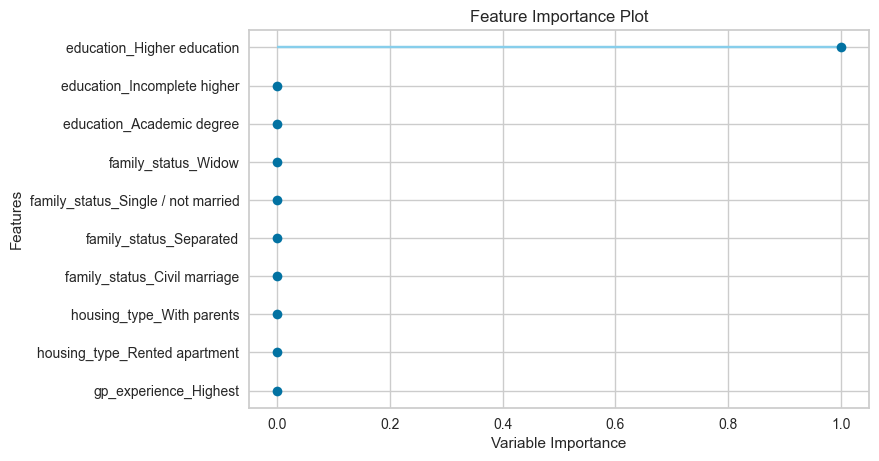

In [68]:
plot_model(tune_gbc,plot='feature')


The Gradient Boost classifier is doing the same, let's try optimizing for F1 instead.

In [56]:
tune_gbc_f1 = tune_model(gbc, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7814,0.6550,0.3724,0.2368,0.2895,0.1679,0.1739
1,0.7781,0.6877,0.4291,0.2495,0.3155,0.1940,0.2042
2,0.7789,0.6816,0.4014,0.2422,0.3021,0.1802,0.1883
3,0.7925,0.6952,0.4152,0.2643,0.3230,0.2076,0.2149
4,0.7863,0.6891,0.3931,0.2500,0.3056,0.1867,0.1934
5,0.7880,0.6908,0.3966,0.2533,0.3091,0.1910,0.1977
6,0.7677,0.6749,0.4345,0.2400,0.3092,0.1833,0.1950
7,0.7929,0.7137,0.4759,0.2828,0.3548,0.2408,0.2524
8,0.7979,0.6822,0.4414,0.2807,0.3432,0.2306,0.2389


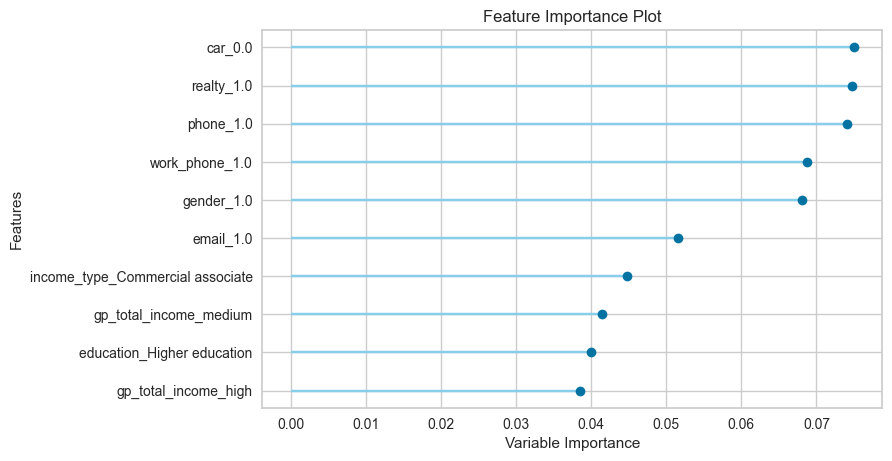

In [57]:
plot_model(tune_gbc_f1,plot='feature')

This looks a bit better but still worse than the random forest when it comes to recall. Let's optimize the random forest for F1 instead.

In [69]:
tune_rf_f1 = tune_model(rf,optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4837,0.4680,0.4517,0.1070,0.1731,-0.0252,-0.0391
1,0.4880,0.5225,0.5675,0.1281,0.2091,0.0180,0.0291
2,0.4670,0.4950,0.5467,0.1198,0.1965,0.0011,0.0019
3,0.5454,0.5323,0.5087,0.1328,0.2106,0.0265,0.0384
4,0.5066,0.5415,0.5897,0.1370,0.2224,0.0350,0.0552
5,0.5083,0.5051,0.5034,0.1223,0.1968,0.0053,0.0080
6,0.4922,0.4831,0.4793,0.1140,0.1842,-0.0112,-0.0174
7,0.5173,0.5038,0.4897,0.1220,0.1953,0.0047,0.0070
8,0.5066,0.4891,0.4621,0.1141,0.1831,-0.0109,-0.0164


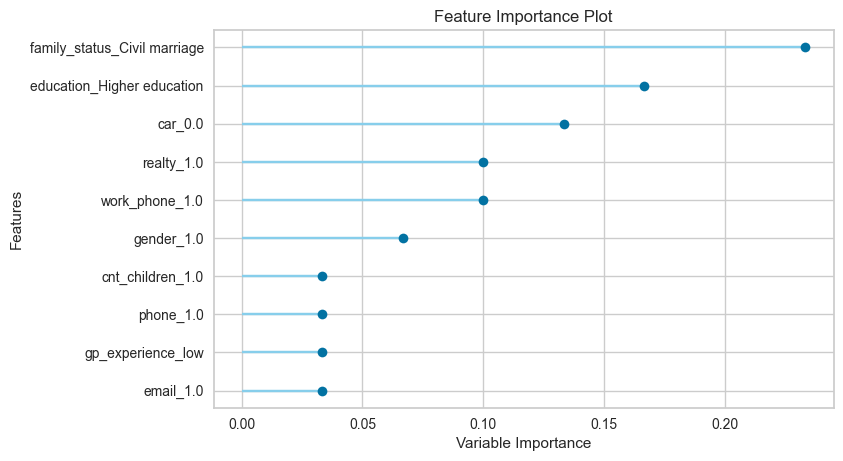

In [73]:
plot_model(tune_rf_f1, plot='feature')

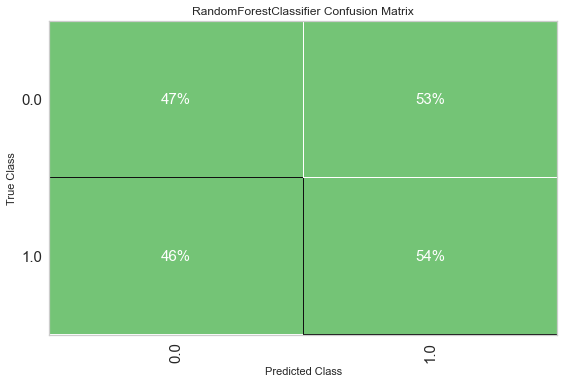

In [72]:
plot_model(tune_rf_f1, plot='confusion_matrix',plot_kwargs= {'percent': True})

About the same, seems like the rf classifier is going to be as good as it gets. Let's predict on our holdout data and see how well we do.

In [77]:
pred = predict_model(tune_rf_f1, raw_score = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.4820,0.5153,0.5366,0.1190,0.1948,0.0045,0.0073


count    6081.000000
mean        0.501553
std         0.010904
min         0.480000
25%         0.492800
50%         0.499000
75%         0.508200
max         0.548200
Name: Score_0.0, dtype: float64

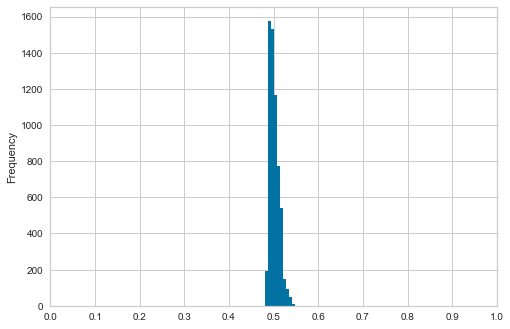

In [94]:
pred['Score_0.0'].plot(kind='hist',xticks=np.linspace(0,1,11))
pred['Score_0.0'].describe()

Seems like we don't get very far out from the .5 probability mark, meaning we aren't very confident in our predictions. This algorithim could be improved with further tweaking.

# Conclusions

## Which are the biggest contributors to good or bad credit?
Bad credit being defined as number of months where a loan is >= 90 days overdue. Good credit defined as no loan, loan for the month paid off or less than 30 days past due.
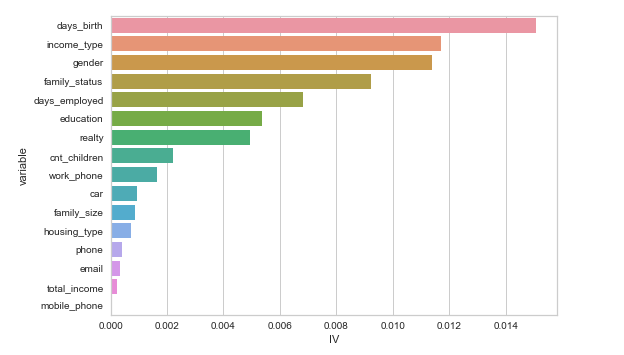

As we can see here the 5 biggest contributors are age, type of income, gender, marital status and how long they've been employed. 

## ML Model to predict defaults on loans (5 in credit status at any time)

We created a model that can predict with 54% recall if someone will default on their loan based on the variables above. The tradeoff is our accuracy is only 50% with many false positives. While this isn't an exciting result it can be extremely valuable. If such a small percent of the population was going to default on a loan and you can reduce that number by 50% risk exposure goes down by a lot. We also found out that higher education is a majorly important feature in whether or not someone defaults. If you had enough clients giving loans to that group exclusively would be very safe.

Here are the feature importances of the best model we could create:



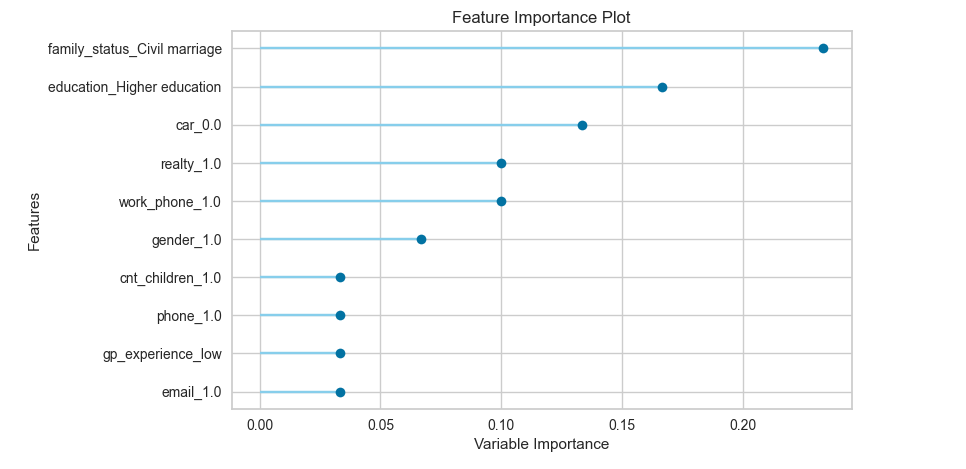